# Ex 1 CNN Implementation (8 pts)

**Note:** Please mention your Python version (and maybe the version of all other packages).


In this exercise you are going to run some experiments involving CNNs. You need to know [Python](https://www.python.org/) and install the following libraries: [Pytorch](https://pytorch.org/get-started/locally/), [matplotlib](https://matplotlib.org/) and all their dependencies. You can find detailed instructions and tutorials for each of these libraries on the respective websites.

For all experiments, running on CPU is sufficient. You do not need to run the code on GPUs, although you could, using for instance [Google Colab](https://colab.research.google.com/). Before start, we suggest you review what we learned about each layer in CNN, and read at least this [tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html).





## Part 1
Implement and train a VGG11 net on the [MNIST](https://pytorch.org/vision/stable/datasets.html#mnist) dataset. VGG11 was an earlier version of VGG16 and can be found as model A in Table 1 of this [paper](https://arxiv.org/pdf/1409.1556.pdf), whose Section 2.1 also gives you all the details about each layer.
The goal is to get the loss as close to 0 as possible. Note that our input dimension is different from the VGG paper. You need to resize each image in MNIST from its original size $28 \times 28$ to $32 \times 32$ [why?].

For your convenience, we list the details of the VGG11 architecture here.
The convolutional layers are denoted as `Conv(number of input channels, number of output channels, kernel size, stride, padding)`;
the batch normalization layers  are denoted as `BatchNorm(number of channels)`; 	the max-pooling layers are denoted as `MaxPool(kernel size, stride)`;	the fully-connected layers are denoted as `FC(number of input features, number of output features)`; the drop out layers are denoted as `Dropout(dropout ratio)`:

			- Conv(001, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)
			- Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
			- Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
			- Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
			- Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
			- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
			- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
			- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
			- FC(0512, 4096) - ReLU - Dropout(0.5)
			- FC(4096, 4096) - ReLU - Dropout(0.5)
			- FC(4096, 10)

You should use the [cross-entropy loss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) `torch.nn.CrossEntropyLoss` at the end.

This experiment will take up to 1 hour on a CPU, so please be cautious of your time. If this running time is not bearable, you may cut the training set to 1/10, so only have $\sim$600 images per class instead of the regular $\sim$6000.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass
import os

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_block = nn.Sequential(
            # 1
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 2
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 3
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 4
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 5
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 6
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 7
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 8
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        features = self.cnn_block(x)
        output = self.classifier(features.flatten(1))
        return output

## Part 2


Once you've done the above, the next goal is to inspect the training process. <u> Create the following plots </u>:

a. (1 pt) test accuracy vs the number of epochs (say 3 $\sim$ 5)

b. (1 pt) training accuracy vs the number of epochs

c. (1 pt) test loss vs the number of epochs

d. (1 pt) training loss vs the number of epochs

[If running more than 1 epoch is computationally infeasible, simply run 1 epoch and try to record the accuracy/loss after every few minibatches.]



In [22]:
# auxiliary functions

def train(args, model, device, train_loader, optimizer, epoch):
    loss_fn = nn.CrossEntropyLoss()
    model.train()

    train_loss_total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        with torch.no_grad():
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_fn(output, target)
        loss.backward()
        train_loss_total+=loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss = train_loss_total/(len(train_loader.dataset))
    train_acc = correct / len(train_loader.dataset)

    print('Train Epoch: {} \n Training set: Average loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
        epoch, train_loss, correct, len(train_loader.dataset),
        train_acc * 100))
    return train_loss, train_acc


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = test_loss / (len(test_loader.dataset))
    test_acc =  correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_acc))

    return test_loss, test_acc

### Train the model

In [23]:
@dataclass
class config:
    batch_size : int = 64
    test_batch_size: int = 64
    epochs: int = 6
    lr: float = 0.001
    gamma: float = 0.7
    seed : int = 1
    log_interval : int = 10
    save_model: bool = True
    no_cuda: bool = False

args = config()

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': False}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


# configure dataloader

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images from 28x28 to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the images
])

trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
testset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(testset, **test_kwargs)

# initialize model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# start training
for epoch in range(1, args.epochs + 1):
    train_loss, train_acc = train(args, model, device, train_loader, optimizer, epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    test_loss, test_acc = test(args, model, device, test_loader)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)

if args.save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325691
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.222289
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.110060
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.924900
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.495836
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.202359
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.824176
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.633654
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.617162
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.362805
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.317440
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.137196
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.194897
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.127630
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.114041
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.182205
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.353806
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.101498
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.245194
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.102703
Train Epoch: 1 [12800/60000 (

### Plot graphs

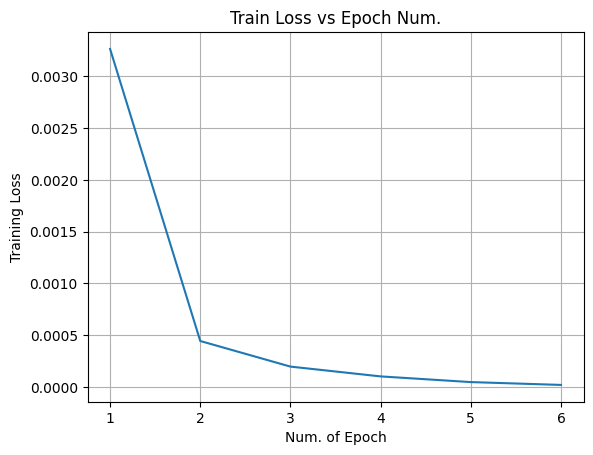

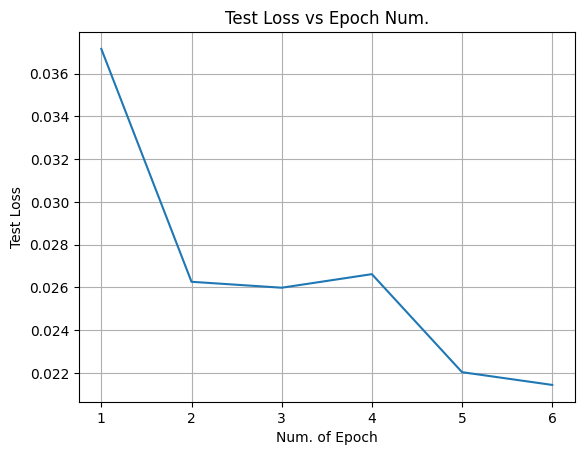

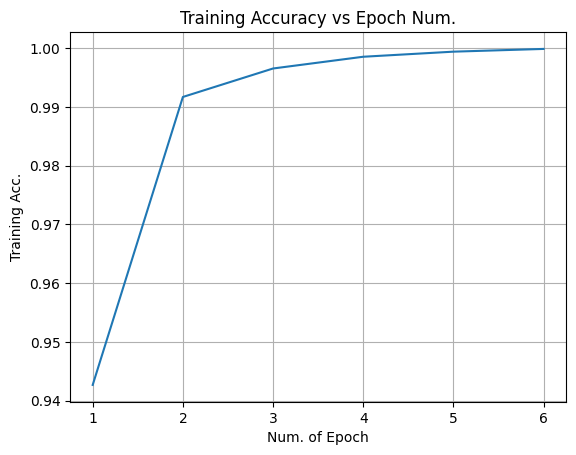

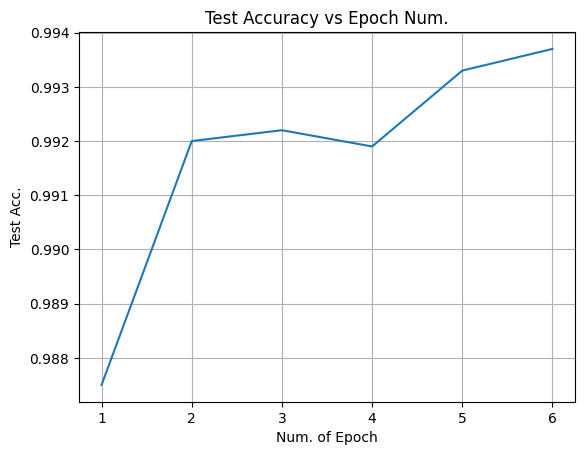

In [24]:

import matplotlib.pyplot as plt
import numpy as np


# (a)
plt.title('Train Loss vs Epoch Num.')
plt.plot(np.arange(args.epochs)+1, train_loss_hist)
plt.grid(True)
plt.xlabel('Num. of Epoch')
plt.ylabel('Training Loss')
plt.show()

# (b)
plt.clf()
plt.title('Test Loss vs Epoch Num.')
plt.plot(np.arange(args.epochs)+1, test_loss_hist)
plt.grid(True)
plt.xlabel('Num. of Epoch')
plt.ylabel('Test Loss')
plt.show()

# (c)
plt.clf()
plt.title('Training Accuracy vs Epoch Num.')
plt.plot(np.arange(args.epochs)+1, train_acc_hist)
plt.grid(True)
plt.xlabel('Num. of Epoch')
plt.ylabel('Training Acc.')
plt.show()

# (d)
plt.clf()
plt.title('Test Accuracy vs Epoch Num.')
plt.plot(np.arange(args.epochs)+1, test_acc_hist)
plt.grid(True)
plt.xlabel('Num. of Epoch')
plt.ylabel('Test Acc.')
plt.show()

## Part 3

Then, it is time to inspect the generalization properties of your final model. Flip and blur the \red{test set images} using any python library of your choice, and complete the following:

e. (1 pt) test accuracy vs type of flip. Try the following two types of flipping: flip each image from left to right, and from top to bottom. <u>{Report the test accuracy after each flip. What is the effect?</u>


You can read this [doc](https://pytorch.org/vision/stable/transforms.html) to learn how to build a complex transformation pipeline. We suggest the following command for performing flipping:

```
  torchvision.transforms.RandomHorizontalFlip(p=1)
  torchvision.transforms.RandomVerticalFlip(p=1)
```

f. (1 pt) test accuracy vs Gaussian noise. Try adding standard Gaussian noise to each test image with variance 0.01, 0.1, 1 and <u>report the test accuracies. What is the effect?</u>

For instance, you may apply a user-defined lambda as a new transform t which adds Gaussian noise with variance say 0.01:

```
t = torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))
```


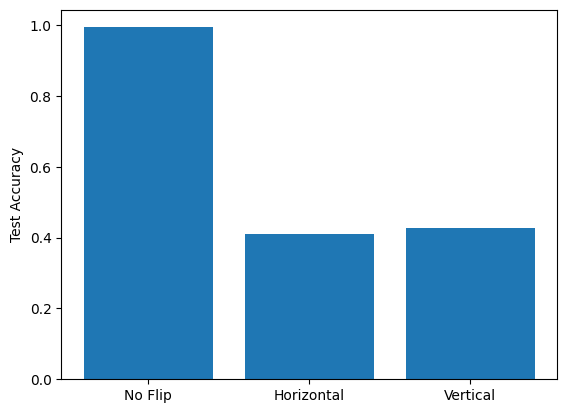

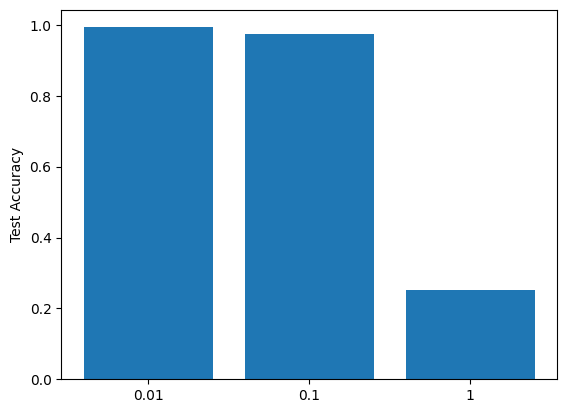

In [27]:
import matplotlib.pyplot as plt

def get_test_result(model, device, test_loader, transform):
    model.eval()
    test_loss = 0
    correct = 0

    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data = transform(data)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    return test_loss, correct / len(test_loader.dataset)

def perform_test(transform, model, device, test_kwargs):
    test_loss, test_acc = get_test_result(model, device, test_loader, transform)
    return test_acc


def test_model(model, args):
    # Training settings
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        test_kwargs.update(cuda_kwargs)

    model.eval()

    ## (e)
    flip_exp_name = ['No Flip', 'Horizontal', 'Vertical']
    test_acc_flip = []

    # no flip
    transform=transforms.Compose([
        ])
    test_acc_flip.append(perform_test(transform, model, device, test_kwargs))

    # Horizontal
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        ])
    test_acc_flip.append(perform_test(transform, model, device, test_kwargs))

    # Vertical
    transform=transforms.Compose([
        transforms.RandomVerticalFlip(p=1),
        ])
    test_acc_flip.append(perform_test(transform, model, device, test_kwargs))

    plt.bar(flip_exp_name, test_acc_flip)
    plt.ylabel('Test Accuracy')
    plt.show()

    ## (f)
    var_lst = [0.01, 0.1, 1]
    test_acc_noise = []
    for var in var_lst:
        transform=transforms.Compose([
            transforms.Lambda(lambda x : x + (var**0.5)*torch.randn_like(x)),
        ])
        test_acc_noise.append(perform_test(transform, model, device, test_kwargs))

    plt.bar([str(var) for var in var_lst], test_acc_noise)
    plt.ylabel('Test Accuracy')
    plt.show()


test_model(model, args)

## Part 4

(2 pts) Lastly, let us verify the effect of regularization. Retrain your model with data augmentation and test again as in item~3 above (both e and f). <u>Report the test accuracy and explain</u> what kind of data augmentation you use in retraining.

In [32]:
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")


train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.Lambda(lambda x : x + torch.randint(0, 2, (1,)) * torch.randn_like(x)),
    ])
dataset1 = datasets.MNIST('data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)
    optimizer.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321687
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.354346
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.332359
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.263882
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.305428
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.326327
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.246949
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.311156
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.197517
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.038236
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.264664
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.072949
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.953311
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.898127
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.854378
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.755749
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.734871
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.693616
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.549652
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.345612
Train Epoch: 1 [12800/60000 (

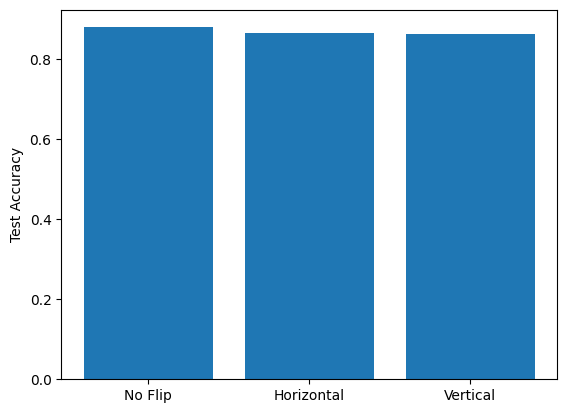

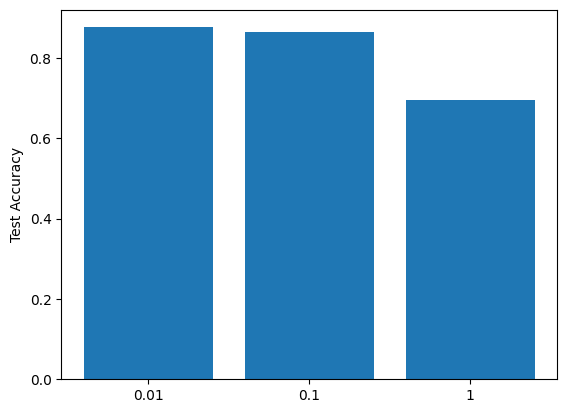

In [33]:
test_model(model, args)